**Домашнее задание**

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from math import log as log

import numpy as np

**Часть 1**
1) реализовать аналогичного изученному дерева решений, использующего энтропию Шенонна в качестве критерия информативности и сравнить точность(accuracy, balanced_accuracy) достигаемую на используемых синтетических данных с точностью разобранной на уроке реализации 


**Базовый класс дерева решений**

In [2]:
# Класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# Класс листа

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [3]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity


def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    quality = current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)
        
    return quality


# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 10

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)



def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return np.array(classes)

**Сгенерируем тестовые данные**

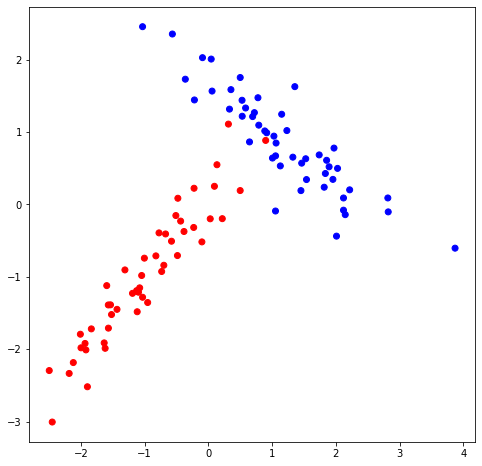

In [4]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=65)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [5]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    return np.sum(actual==predicted)/len(actual)

def balanced_accuracy_metric(actual, predicted):
    true_predicted=(actual==predicted).astype(int)
    sensitivity=np.sum(actual*true_predicted)/np.sum(actual==1)
    specificity=np.sum((1-actual)*true_predicted)/np.sum(actual==0)
    return 0.5*(sensitivity+specificity)

Построим дерево по базовой модели.

In [6]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 42)

# Построим дерево по обучающей выборке
my_tree_basic = build_tree(train_data, train_labels)

In [7]:
# Получим ответы для обучающей выборки 
train_answers_basic = predict(train_data, my_tree_basic)

# И получим ответы для тестовой выборки
answers_basic = predict(test_data, my_tree_basic)

In [8]:
# Точность на обучающей выборке
train_accuracy_basic=accuracy_metric(train_labels, train_answers_basic)
accuracy_metric(train_labels, train_answers_basic), balanced_accuracy_metric(train_labels, train_answers_basic)

(0.9142857142857143, 0.9065343258891646)

In [9]:
# Точность на тестовой выборке
test_accuracy_basic=accuracy_metric(test_labels, answers_basic)
accuracy_metric(test_labels, answers_basic), balanced_accuracy_metric(test_labels, answers_basic)

(0.8666666666666667, 0.8755980861244019)

Заменим критерий Джини на энтропию Шеннона.

In [10]:
def shennon(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    p = []
    for label in classes:
        pk = classes[label] / len(labels)
        p.append(pk * log(pk))
        
    impurity = - np.sum(p)    
    return impurity    

In [11]:
def quality(left_labels, right_labels, current_shennon):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    quality = current_shennon - p * shennon(left_labels) - (1 - p) * shennon(right_labels)
    return quality


# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 10

    current_shennon = shennon(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_shennon)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции

def build_tree_shennon(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_shennon(true_data, true_labels)
    false_branch = build_tree_shennon(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)



def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return np.array(classes)

Построим дерево на модели с энтропией Шеннона.

In [12]:
# Построим дерево по обучающей выборке
my_tree_shennon = build_tree_shennon(train_data, train_labels)

In [13]:
# Получим ответы для обучающей выборки 
train_answers_shennon = predict(train_data, my_tree_shennon)

# И получим ответы для тестовой выборки
answers_shennon = predict(test_data, my_tree_shennon)

In [14]:
# Точность на обучающей выборке
train_accuracy_shennon=accuracy_metric(train_labels, train_answers_shennon)
accuracy_metric(train_labels, train_answers_shennon), balanced_accuracy_metric(train_labels, train_answers_shennon)

(0.9142857142857143, 0.9230769230769231)

In [15]:
# Точность на тестовой выборке
test_accuracy_shennon=accuracy_metric(test_labels, answers_shennon)
accuracy_metric(test_labels, answers_shennon), balanced_accuracy_metric(test_labels, answers_shennon)

(0.8666666666666667, 0.8181818181818181)

In [16]:
train_accuracy_shennon == train_accuracy_basic

True

In [17]:
balanced_accuracy_metric(test_labels, answers_shennon) == balanced_accuracy_metric(test_labels, answers_basic)

False

In [18]:
dif = balanced_accuracy_metric(test_labels, answers_shennon) - balanced_accuracy_metric(test_labels, answers_basic)
dif

-0.05741626794258381

Модель c энтропией Шеннона показала результаты хуже, чем модель с критерием Джини (сбалансированная метрика точности меньше на 0.057).

<ipython-input-19-46c26fc85c07>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-19-46c26fc85c07>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=0.87')

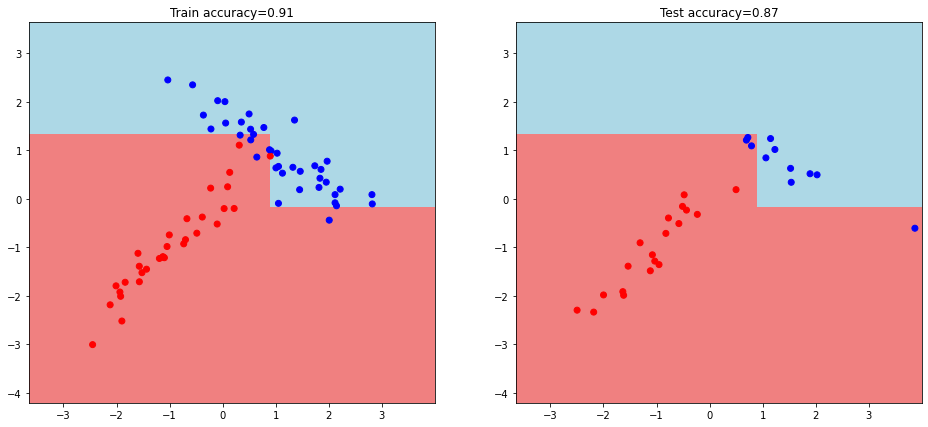

In [19]:
# Визуализируем дерево c Энтропией Шеннона на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_shennon)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_shennon:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_shennon:.2f}')

Реализуем ограничение глубины дерева при построении. Построим на этом же датасете дерево, у которого максимальная глубина листа равна 2.
Перепишем функцию build tree, установив дополнительный параметр max_deep. 


In [22]:
# Построение дерева с помощью рекурсивной функции

def build_tree_shennon_max(data, labels, max_deep):
    
    if max_deep > 0:
        quality, t, index = find_best_split(data, labels)
    else:
        return Leaf(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_shennon_max(true_data, true_labels, max_deep-1)
    false_branch = build_tree_shennon_max(false_data, false_labels, max_deep-1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Построим дерево, у которого максимальная глубина равна 2.

In [23]:
# Построим дерево по обучающей выборке
my_tree_shennon_max = build_tree_shennon_max(train_data, train_labels, 2)

In [24]:
# Получим ответы для обучающей выборки 
train_answers_shennon_max = predict(train_data, my_tree_shennon_max)

# И получим ответы для тестовой выборки
answers_shennon_max = predict(test_data, my_tree_shennon_max)

In [25]:
# Точность на обучающей выборке
train_accuracy_shennon_max=accuracy_metric(train_labels, train_answers_shennon_max)
accuracy_metric(train_labels, train_answers_shennon_max), balanced_accuracy_metric(train_labels, train_answers_shennon_max)

(0.9142857142857143, 0.9065343258891646)

In [26]:
# Точность на тестовой выборке
test_accuracy_shennon_max=accuracy_metric(test_labels, answers_shennon_max)
accuracy_metric(test_labels, answers_shennon_max), balanced_accuracy_metric(test_labels, answers_shennon_max)

(0.8666666666666667, 0.8755980861244019)

In [27]:
dif_am = test_accuracy_shennon - test_accuracy_shennon_max
dif_am

0.0

In [28]:
dif_bam = balanced_accuracy_metric(test_labels, answers_shennon) - balanced_accuracy_metric(test_labels, answers_shennon_max)
dif_bam

-0.05741626794258381

Модель с ограничением максимальной глубины показала лучшие результаты.